# Read Data

In [2]:
import pandas as pd

def load_and_clean_data(csv_file):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)

    # Drop unnecessary columns
    df.drop(columns=['coin', 'volume', 'closetime', 'quotevolume', 'trades', 'taker_buy_volume', 'taker_buy_quote', 'unused'], inplace=True)

    # Return the cleaned DataFrame
    return df

In [3]:
df = load_and_clean_data('SOL_USDT_futures_data_2020.csv')
df

,opentime,openprice,highprice,lowprice,closeprice
0,1600066800000,3.2002,4.9100,3.2002,3.3666
1,1600070400000,3.3663,3.5650,3.3000,3.3298
2,1600074000000,3.3298,3.3567,3.2161,3.2755
3,1600077600000,3.2753,3.3873,3.2500,3.3673
4,1600081200000,3.3686,3.4600,3.3200,3.3799
...,...,...,...,...,...
37649,1735603200000,191.2600,191.9600,189.9000,189.9800
37650,1735606800000,189.9900,190.3600,188.2400,189.1000
37651,1735610400000,189.1000,190.7500,188.7100,190.1900
37652,1735614000000,190.1900,190.6900,189.3900,189.8400


# Fetch Data

In [3]:
import requests
import pandas as pd
from datetime import datetime
from tqdm import tqdm

BINANCE_CANDLE_COLUMNS = ['opentime', 'openprice', 'highprice', 'lowprice', 'closeprice', 'volume', 'closetime',
                          'quotevolume', 'trades', 'taker_buy_volume', 'taker_buy_quote', 'unused']

def binance_recursive_fetch_2(coins, interval, starttime, endtime, data_type='spot'):
    all_coins_result = {}
    data_list = []
    call_dict = {}
    
    for coin in tqdm(coins):
        result_list = []
        current_time = starttime
        call = 0
        timestamps = []
        
        while current_time < endtime:
            if ((int((endtime - current_time) / (1000 * 60))) + 1) >= 1000:
                limit = 1000
            else:
                limit = int((endtime - current_time) / (1000 * 60) + 1)
            
            if data_type == 'spot':
                url = (f'https://api.binance.com/api/v3/klines'
                       f'?symbol={coin}USDT'
                       f'&startTime={str(current_time)}'
                       f'&interval={interval}'
                       f'&limit={str(limit)}')
            elif data_type == 'futures':
                url = (f'https://fapi.binance.com/fapi/v1/klines'
                       f'?symbol={coin}USDT'
                       f'&startTime={str(current_time)}'
                       f'&interval={interval}'
                       f'&limit={str(limit)}')
            
            result_list += requests.get(url).json()
            
            if result_list:
                # Update current_time with the timestamp of the last data point fetched, plus 1 minute (60000 ms)
                current_time = result_list[-1][0] + 60000
                timestamps.append(current_time)
                call += 1
                
                # Check if the last fetched timestamp is greater than or equal to endtime
                if current_time >= endtime:
                    print(f"Reached endtime at {datetime.fromtimestamp(current_time / 1000).strftime('%Y-%m-%d %H:%M:%S')}. Stopping fetch.")
                    break
                
                print((datetime.fromtimestamp(current_time / 1000).strftime('%Y-%m-%d %H:%M:%S')) + 
                      f' status : {current_time < endtime}, time : {current_time}, limit : {call * 2}')
            
            # Ensure there's no continuous fetching of the same timestamp
            if len(timestamps) > 1 and timestamps[-1] == timestamps[-2]:
                print("Duplicate timestamp detected. Stopping fetch.")
                break
            
            # Sleep if needed to avoid rate limiting (adjust based on your rate limit)
            # time.sleep(0.1)  # Uncomment if needed
            
        current_df = pd.DataFrame(result_list, columns=BINANCE_CANDLE_COLUMNS)
        current_df['coin'] = coin
        current_df = current_df[['coin'] + BINANCE_CANDLE_COLUMNS]
        current_df = current_df.values.tolist()
        
        data_list += current_df
        call_dict.update({coin: call})
    
    return {'data': data_list, 'call': call_dict}

In [4]:
# Fetch COIN USDT
sample_spot = binance_recursive_fetch_2(
    ['SOL'],
    '30m',
    starttime=int(pd.to_datetime('2023-01-01 00:00', utc=True).timestamp() * 1000),
    endtime=int(pd.to_datetime('2026-01-01 00:00', utc=True).timestamp() * 1000),
    data_type='futures'  # Fetch futures/sport
)

# Define the column names for the DataFrame based on the Binance API response structure
columns = ['coin', 'opentime', 'openprice', 'highprice', 'lowprice', 'closeprice', 'volume', 'closetime', 
           'quotevolume', 'trades', 'taker_buy_volume', 'taker_buy_quote', 'unused']

# Convert the list of data into a DataFrame
df = pd.DataFrame(sample_spot['data'], columns=columns)

# Drop unnecessary columns
df.drop(columns=(['coin','volume','closetime','quotevolume','trades','taker_buy_volume','taker_buy_quote','unused']), inplace=True)

# Convert columns 1-4 (openprice, highprice, lowprice, closeprice) to float
df[['openprice', 'highprice', 'lowprice', 'closeprice']] = df[['openprice', 'highprice', 'lowprice', 'closeprice']].apply(pd.to_numeric, errors='coerce')

# add date filter
df = df[df['opentime'] <= 1735689600000] # end of 2024

# Show the first few rows of the DataFrame
df

  0%|          | 0/1 [00:00<?, ?it/s]

2023-01-21 19:31:00 status : True, time : 1674329460000, limit : 2
2023-02-11 15:31:00 status : True, time : 1676129460000, limit : 4
2023-03-04 11:31:00 status : True, time : 1677929460000, limit : 6
2023-03-25 07:31:00 status : True, time : 1679729460000, limit : 8
2023-04-15 03:31:00 status : True, time : 1681529460000, limit : 10
2023-05-05 23:31:00 status : True, time : 1683329460000, limit : 12
2023-05-26 19:31:00 status : True, time : 1685129460000, limit : 14
2023-06-16 15:31:00 status : True, time : 1686929460000, limit : 16
2023-07-07 11:31:00 status : True, time : 1688729460000, limit : 18
2023-07-28 07:31:00 status : True, time : 1690529460000, limit : 20
2023-08-18 03:31:00 status : True, time : 1692329460000, limit : 22
2023-09-07 23:31:00 status : True, time : 1694129460000, limit : 24
2023-09-28 19:31:00 status : True, time : 1695929460000, limit : 26
2023-10-19 15:31:00 status : True, time : 1697729460000, limit : 28
2023-11-09 11:31:00 status : True, time : 1699529460

100%|██████████| 1/1 [00:04<00:00,  4.32s/it]

2025-01-18 04:31:00 status : True, time : 1737174660000, limit : 72
2025-01-18 04:31:00 status : True, time : 1737174660000, limit : 74
Duplicate timestamp detected. Stopping fetch.


,opentime,openprice,highprice,lowprice,closeprice
0,1672531200000,9.968,10.016,9.923,10.011
1,1672533000000,10.011,10.012,9.931,9.979
2,1672534800000,9.980,10.060,9.970,10.037
3,1672536600000,10.037,10.059,10.003,10.032
4,1672538400000,10.031,10.074,9.981,10.044
...,...,...,...,...,...
35084,1735682400000,193.050,193.050,191.140,191.920
35085,1735684200000,191.930,192.130,190.590,191.070
35086,1735686000000,191.070,191.080,189.860,190.430
35087,1735687800000,190.420,190.420,189.040,189.220


# Add Super Trend Indicator

In [2]:
import pandas as pd
import numpy as np
from pandas_ta.overlap import hl2
from pandas_ta.volatility import atr
from pandas_ta.utils import get_offset, verify_series

npNaN = np.nan

def calculate_supertrend(df, high_col='highprice', low_col='lowprice', close_col='closeprice', length=10, multiplier=3.0, offset=0, drop_columns=True, **kwargs):
    """
    Calculate the Supertrend indicator and merge it with the original DataFrame.
    
    Parameters:
        df (DataFrame): Original DataFrame containing the OHLC data.
        high_col (str): Name of the high price column. Default is 'highprice'.
        low_col (str): Name of the low price column. Default is 'lowprice'.
        close_col (str): Name of the close price column. Default is 'closeprice'.
        length (int): Lookback period for ATR calculation. Default is 10.
        multiplier (float): Multiplier for ATR. Default is 3.0.
        offset (int): Number of periods to shift the result. Default is 0.
        drop_columns (bool): Whether to drop intermediate columns. Default is True.
        **kwargs: Additional arguments for handling NaN values (e.g., fillna).
    
    Returns:
        DataFrame: The original DataFrame with Supertrend columns merged.
    """
    # Validate Arguments
    high = verify_series(df[high_col], length)
    low = verify_series(df[low_col], length)
    close = verify_series(df[close_col], length)
    offset = get_offset(offset)

    if high is None or low is None or close is None:
        return df

    m = close.size
    dir_, trend = [1] * m, [0] * m
    long, short = [np.nan] * m, [np.nan] * m

    hl2_ = hl2(high, low)
    matr = multiplier * atr(high, low, close, length)
    upperband = hl2_ + matr
    lowerband = hl2_ - matr

    for i in range(1, m):
        if close.iloc[i] > upperband.iloc[i - 1]:
            dir_[i] = 1
        elif close.iloc[i] < lowerband.iloc[i - 1]:
            dir_[i] = -1
        else:
            dir_[i] = dir_[i - 1]
            if dir_[i] > 0 and lowerband.iloc[i] < lowerband.iloc[i - 1]:
                lowerband.iloc[i] = lowerband.iloc[i - 1]
            if dir_[i] < 0 and upperband.iloc[i] > upperband.iloc[i - 1]:
                upperband.iloc[i] = upperband.iloc[i - 1]

        if dir_[i] > 0:
            trend[i] = long[i] = lowerband.iloc[i]
        else:
            trend[i] = short[i] = upperband.iloc[i]

    _props = f"_{length}_{multiplier}"
    supertrend_df = pd.DataFrame({
        f"SUPERT{_props}": trend,
        f"SUPERTd{_props}": dir_,
        f"SUPERTl{_props}": long,
        f"SUPERTs{_props}": short,
    }, index=close.index)

    # Apply offset if needed
    if offset != 0:
        supertrend_df = supertrend_df.shift(offset)

    # Handle fills
    if "fillna" in kwargs:
        supertrend_df.fillna(kwargs["fillna"], inplace=True)
    if "fill_method" in kwargs:
        supertrend_df.fillna(method=kwargs["fill_method"], inplace=True)

    # Merge with original DataFrame
    result_df = df.join(supertrend_df)

    # Drop unnecessary columns
    if drop_columns:
        result_df.drop(columns=[f"SUPERT{_props}", f"SUPERTd{_props}"], inplace=True)

    return result_df

In [5]:
# Example usage
supertrend_df = calculate_supertrend(df, length=10, multiplier=3.0)
supertrend_df

,opentime,openprice,highprice,lowprice,closeprice,SUPERTl_10_3.0,SUPERTs_10_3.0
0,1672531200000,9.968,10.016,9.923,10.011,NaN,NaN
1,1672533000000,10.011,10.012,9.931,9.979,NaN,NaN
2,1672534800000,9.980,10.060,9.970,10.037,NaN,NaN
3,1672536600000,10.037,10.059,10.003,10.032,NaN,NaN
4,1672538400000,10.031,10.074,9.981,10.044,NaN,NaN
...,...,...,...,...,...,...,...
35084,1735682400000,193.050,193.050,191.140,191.920,NaN,196.765500
35085,1735684200000,191.930,192.130,190.590,191.070,NaN,196.025450
35086,1735686000000,191.070,191.080,189.860,190.430,NaN,195.034905
35087,1735687800000,190.420,190.420,189.040,189.220,NaN,194.255414


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates

supertrend_df_sample = supertrend_df.tail(200)
supertrend_df_sample

# Assuming `supertrend_df` is already loaded
# Convert 'opentime' to datetime and set up plotting data
supertrend_df_sample['opentime'] = pd.to_datetime(supertrend_df_sample['opentime'], unit='ms')
supertrend_df_sample['date_num'] = mdates.date2num(supertrend_df_sample['opentime'])

# Prepare OHLC data for candlestick plot
ohlc = supertrend_df_sample[['date_num', 'openprice', 'highprice', 'lowprice', 'closeprice']].dropna().values

# Plot configuration
fig, ax = plt.subplots(figsize=(15, 7))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.title('Candlestick Chart with Supertrend Indicators', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)

# Plot candlestick chart
candlestick_ohlc(ax, ohlc, width=0.02, colorup='dodgerblue', colordown='orangered', alpha=0.8)

# Plot SUPERTl_10_3.0 (green) and SUPERTs_10_3.0 (red)
ax.plot(supertrend_df_sample['date_num'], supertrend_df_sample['SUPERTl_10_3.0'], color='dodgerblue', label='Up Trend')
ax.plot(supertrend_df_sample['date_num'], supertrend_df_sample['SUPERTs_10_3.0'], color='orangered', label='Down Trend')

# Add legend
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

# Add Ichimoku Cloud Indicator

In [7]:
import pandas as pd
import numpy as np

def compute_ichimoku_with_supertrend(supertrend_df, conversion_periods=9, base_periods=26, span_b_periods=52, displacement=26):
    """
    Compute Ichimoku Cloud components and join them with the original supertrend DataFrame.
    
    Parameters:
    - supertrend_df (DataFrame): The input DataFrame with 'highprice', 'lowprice', and 'closeprice' columns.
    - conversion_periods (int): Period for the Conversion Line (Tenkan-sen). Default is 9.
    - base_periods (int): Period for the Base Line (Kijun-sen). Default is 26.
    - span_b_periods (int): Period for Leading Span B (Senkou Span B). Default is 52.
    - displacement (int): Displacement for Leading Spans. Default is 26.
    
    Returns:
    - DataFrame: A DataFrame that combines the original supertrend DataFrame with the computed Ichimoku Cloud components.
    """
    # Helper to calculate the average of the highest high and lowest low
    def donchian(data, period):
        return (data['highprice'].rolling(window=period).max() + 
                data['lowprice'].rolling(window=period).min()) / 2

    # Compute Ichimoku Cloud components
    supertrend_df['conversion_line'] = donchian(supertrend_df, conversion_periods)
    supertrend_df['base_line'] = donchian(supertrend_df, base_periods)
    supertrend_df['leading_span_a'] = ((supertrend_df['conversion_line'] + supertrend_df['base_line']) / 2).shift(displacement)
    supertrend_df['leading_span_b'] = donchian(supertrend_df, span_b_periods).shift(displacement)
    supertrend_df['lagging_span'] = supertrend_df['closeprice'].shift(-displacement)
    
    # Drop unnecessary columns
    supertrend_df.drop(columns=['conversion_line', 'base_line', 'lagging_span'], inplace=True)
    
    return supertrend_df

In [8]:
# Usage example:
supertrend_ichimoku_df = compute_ichimoku_with_supertrend(supertrend_df)
supertrend_ichimoku_df

,opentime,openprice,highprice,lowprice,closeprice,SUPERTl_10_3.0,SUPERTs_10_3.0,leading_span_a,leading_span_b
0,1672531200000,9.968,10.016,9.923,10.011,NaN,NaN,NaN,NaN
1,1672533000000,10.011,10.012,9.931,9.979,NaN,NaN,NaN,NaN
2,1672534800000,9.980,10.060,9.970,10.037,NaN,NaN,NaN,NaN
3,1672536600000,10.037,10.059,10.003,10.032,NaN,NaN,NaN,NaN
4,1672538400000,10.031,10.074,9.981,10.044,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
35084,1735682400000,193.050,193.050,191.140,191.920,NaN,196.765500,191.3125,191.105
35085,1735684200000,191.930,192.130,190.590,191.070,NaN,196.025450,191.2600,191.105
35086,1735686000000,191.070,191.080,189.860,190.430,NaN,195.034905,191.1400,191.105
35087,1735687800000,190.420,190.420,189.040,189.220,NaN,194.255414,191.4700,191.105


# Add MACD

In [10]:
import pandas as pd
import numpy as np

def compute_macd(supertrend_df, fast_period=12, slow_period=26, signal_period=9):
    """
    Compute MACD and Signal Line and join them with the original supertrend DataFrame.
    
    Parameters:
    - supertrend_df (DataFrame): The input DataFrame with 'highprice', 'lowprice', and 'closeprice' columns.
    - fast_period (int): Period for the fast EMA (12-period). Default is 12.
    - slow_period (int): Period for the slow EMA (26-period). Default is 26.
    - signal_period (int): Period for the Signal line (9-period). Default is 9.
    
    Returns:
    - DataFrame: A DataFrame that combines the original supertrend DataFrame with the computed MACD components.
    """
    # Compute MACD Line (fast EMA - slow EMA)
    supertrend_df['macd_line'] = supertrend_df['closeprice'].ewm(span=fast_period, adjust=False).mean() - supertrend_df['closeprice'].ewm(span=slow_period, adjust=False).mean()
    
    # Compute Signal Line (9-period EMA of the MACD line)
    supertrend_df['signal_line'] = supertrend_df['macd_line'].ewm(span=signal_period, adjust=False).mean()
    
    # Compute Histogram (MACD Line - Signal Line)
    supertrend_df['histogram'] = supertrend_df['macd_line'] - supertrend_df['signal_line']
    
    # Return the DataFrame with MACD, Signal, and Histogram columns
    return supertrend_df

In [11]:
# Usage example:
supertrend_ichimoku_macd_df = compute_macd(supertrend_ichimoku_df)
supertrend_ichimoku_macd_df

,opentime,openprice,highprice,lowprice,closeprice,SUPERTl_10_3.0,SUPERTs_10_3.0,leading_span_a,leading_span_b,macd_line,signal_line,histogram
0,1672531200000,9.968,10.016,9.923,10.011,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
1,1672533000000,10.011,10.012,9.931,9.979,NaN,NaN,NaN,NaN,-0.002553,-0.000511,-0.002042
2,1672534800000,9.980,10.060,9.970,10.037,NaN,NaN,NaN,NaN,0.000103,-0.000388,0.000491
3,1672536600000,10.037,10.059,10.003,10.032,NaN,NaN,NaN,NaN,0.001784,0.000047,0.001737
4,1672538400000,10.031,10.074,9.981,10.044,NaN,NaN,NaN,NaN,0.004038,0.000845,0.003193
...,...,...,...,...,...,...,...,...,...,...,...,...
35084,1735682400000,193.050,193.050,191.140,191.920,NaN,196.765500,191.3125,191.105,-0.140596,0.526325,-0.666920
35085,1735684200000,191.930,192.130,190.590,191.070,NaN,196.025450,191.2600,191.105,-0.371736,0.346713,-0.718448
35086,1735686000000,191.070,191.080,189.860,190.430,NaN,195.034905,191.1400,191.105,-0.599646,0.157441,-0.757087
35087,1735687800000,190.420,190.420,189.040,189.220,NaN,194.255414,191.4700,191.105,-0.867899,-0.047627,-0.820272


# Plot to check

/tmp/ipykernel_1875852/2777483409.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  supertrend_ichimoku_df_sample['opentime'] = pd.to_datetime(supertrend_ichimoku_df_sample['opentime'], unit='ms')
/tmp/ipykernel_1875852/2777483409.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  supertrend_ichimoku_df_sample['date_num'] = mdates.date2num(supertrend_ichimoku_df_sample['opentime'])


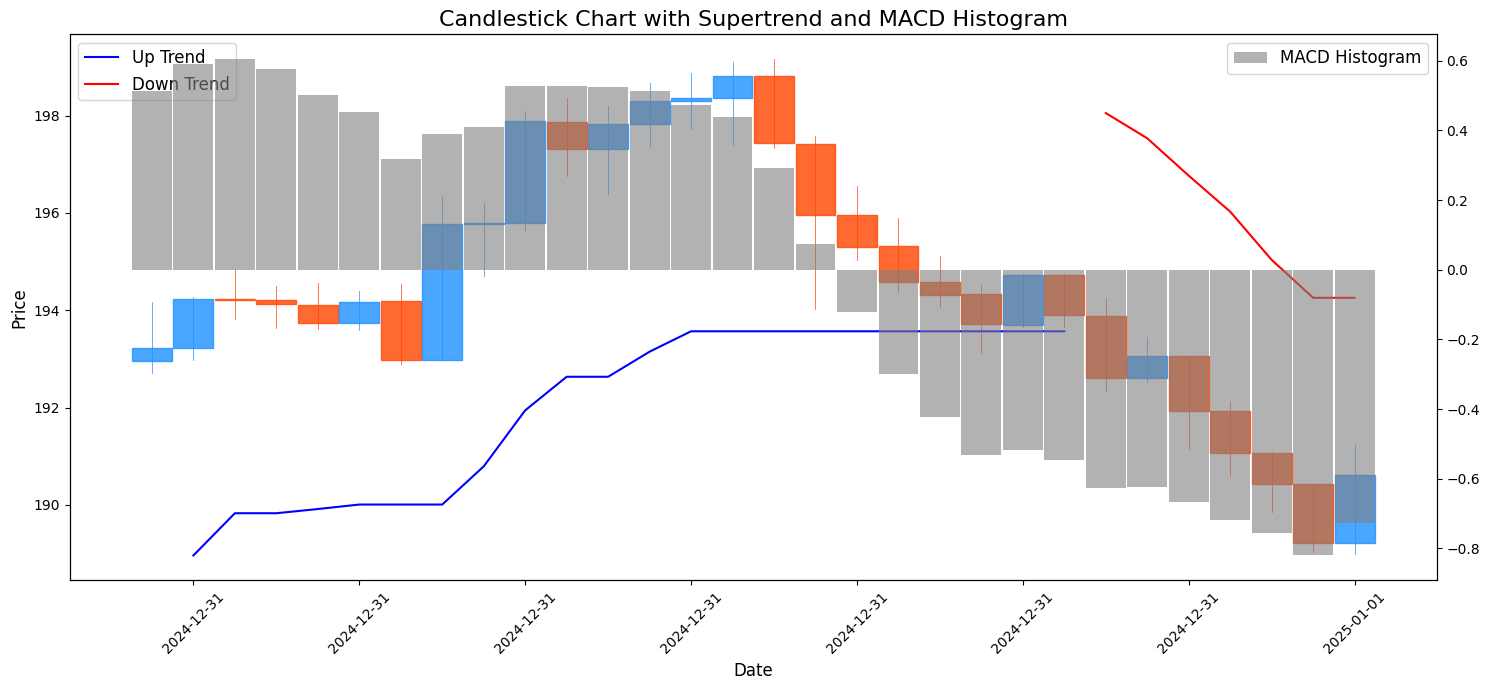

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates

# Assuming `supertrend_ichimoku_df_sample` is already loaded and processed
supertrend_ichimoku_df_sample = supertrend_ichimoku_df.tail(30)

# Convert 'opentime' to datetime and set up plotting data
supertrend_ichimoku_df_sample['opentime'] = pd.to_datetime(supertrend_ichimoku_df_sample['opentime'], unit='ms')
supertrend_ichimoku_df_sample['date_num'] = mdates.date2num(supertrend_ichimoku_df_sample['opentime'])

# Prepare OHLC data for candlestick plot
ohlc = supertrend_ichimoku_df_sample[['date_num', 'openprice', 'highprice', 'lowprice', 'closeprice']].dropna().values

# Plot configuration
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot candlestick chart
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
ax1.set_title('Candlestick Chart with Supertrend and MACD Histogram', fontsize=16)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Price', fontsize=12)

# Candlestick chart
candlestick_ohlc(ax1, ohlc, width=0.02, colorup='dodgerblue', colordown='orangered', alpha=0.8)

# Plot Supertrend Uptrend and Downtrend
ax1.plot(supertrend_ichimoku_df_sample['date_num'], supertrend_ichimoku_df_sample['SUPERTl_10_3.0'], color='blue', label='Up Trend')
ax1.plot(supertrend_ichimoku_df_sample['date_num'], supertrend_ichimoku_df_sample['SUPERTs_10_3.0'], color='red', label='Down Trend')

# Add legend for Supertrend
ax1.legend(loc='upper left', fontsize=12)

# Create a second y-axis to plot the MACD histogram
ax2 = ax1.twinx()

# Plot the MACD histogram
ax2.bar(supertrend_ichimoku_df_sample['date_num'], supertrend_ichimoku_df_sample['histogram'], width=0.02, color='gray', alpha=0.6, label='MACD Histogram')

# Add legend for MACD
ax2.legend(loc='upper right', fontsize=12)

# Tight layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()

# Backtest Signaling

In [16]:
df_backtest = supertrend_ichimoku_macd_df.copy()

# Fill the 'trend' column based on conditions
df_backtest['trend'] = np.where(
    (df_backtest['SUPERTl_10_3.0'].notna()) & (df_backtest['SUPERTs_10_3.0'].isna()), 1,
    np.where(
        (df_backtest['SUPERTs_10_3.0'].notna()) & (df_backtest['SUPERTl_10_3.0'].isna()), -1, np.nan
    )
)

# Rename the last 4 columns
new_column_names = {
    'opentime': 'time',
    'openprice': 'open',
    'highprice': 'high',
    'lowprice': 'low',
    'closeprice': 'close',
    'leading_span_a' : 'ic_a',
    'leading_span_b' : 'ic_b',
    'histogram': 'macd'
}
df_backtest.rename(columns=new_column_names, inplace=True)

# Drop unused columns
df_backtest.drop(columns=['SUPERTl_10_3.0', 'SUPERTs_10_3.0', 'macd_line', 'signal_line'], inplace=True)

# Drop first 50 rows
df_backtest.drop(index=range(77), inplace=True)

# Reset index
df_backtest.reset_index(drop=True,inplace=True)

# Display
df_backtest

,time,open,high,low,close,ic_a,ic_b,macd,trend
0,1672669800000,11.147,11.154,11.072,11.110,9.91825,9.876,-0.012854,1.0
1,1672671600000,11.110,11.156,11.054,11.126,9.91825,9.876,-0.018681,1.0
2,1672673400000,11.126,11.234,11.097,11.108,9.91825,9.876,-0.024969,1.0
3,1672675200000,11.107,11.139,11.081,11.120,9.91825,9.876,-0.029245,1.0
4,1672677000000,11.120,11.174,11.078,11.098,9.90825,9.876,-0.034139,1.0
...,...,...,...,...,...,...,...,...,...
35007,1735682400000,193.050,193.050,191.140,191.920,191.31250,191.105,-0.666920,-1.0
35008,1735684200000,191.930,192.130,190.590,191.070,191.26000,191.105,-0.718448,-1.0
35009,1735686000000,191.070,191.080,189.860,190.430,191.14000,191.105,-0.757087,-1.0
35010,1735687800000,190.420,190.420,189.040,189.220,191.47000,191.105,-0.820272,-1.0


In [17]:
# Check for NaN values in any column
nan_check = df_backtest.isna().sum()

# Print out columns with NaN values
print("Columns with NaN values:")
print(nan_check[nan_check > 0])

Columns with NaN values:
Series([], dtype: int64)


In [23]:
def determine_real_action(df,macd_threshold = 0.00000001):
    """
    Determines the real action ('Open Long', 'Close Long', 'Hold Long', etc.)
    based on the previous action and current trend/criteria.

    Parameters:
    - df (DataFrame): The DataFrame containing the necessary columns.

    Returns:
    - DataFrame: The updated DataFrame with 'Real_Action' column set according to the conditions.
    """

    # Initialize previous action
    prev_action = None
    df['Real_Action'] = None

    # Intiate position count on each trend
    opened_position_on_trend = 0

    # Iterate over the rows and apply the conditions
    for index, row in df.iterrows():

        # Check Trend
        if row['trend'].shift(1) != row['trend']:
            opened_position_on_trend = 0

        # Determine Entry Signal
        if prev_action == None:
            if row['trend'] == 1 and row['macd'] >= macd_threshold and row['close'] >= max(row['ic_a'],row['ic_b']):
                df.at[index, 'Real_Action'] = 'Open Long'
                prev_action = 'Long'
            elif row['trend'] == 1 and row['macd'] >= macd_threshold and row['close'] < max(row['ic_a'],row['ic_b']):
                df.at[index, 'Real_Action'] = None
                prev_action = None
            elif row['trend'] == 1 and row['macd'] <= (-1 * macd_threshold) and row['close'] >= max(row['ic_a'],row['ic_b']):
                df.at[index, 'Real_Action'] = None
                prev_action = None
            elif row['trend'] == 1 and row['macd'] <= (-1 * macd_threshold) and row['close'] < max(row['ic_a'],row['ic_b']):
                df.at[index, 'Real_Action'] = None
                prev_action = None
            elif row['trend'] == 0 and row['macd'] >= macd_threshold and row['close'] >= max(row['ic_a'],row['ic_b']):
                df.at[index, 'Real_Action'] = None
                prev_action = 'Long'
            elif row['trend'] == 0 and row['macd'] >= macd_threshold and row['close'] < max(row['ic_a'],row['ic_b']):
                df.at[index, 'Real_Action'] = None
                prev_action = None
            elif row['trend'] == 0 and row['macd'] <= (-1 * macd_threshold) and row['close'] >= max(row['ic_a'],row['ic_b']):
                df.at[index, 'Real_Action'] = None
                prev_action = None
            elif row['trend'] == 0 and row['macd'] <= (-1 * macd_threshold) and row['close'] < max(row['ic_a'],row['ic_b']):
                df.at[index, 'Real_Action'] = 'Open Short'
                prev_action = 'Short'

        elif prev_action == 'Short':
            if row['trend'] == 1 and row['macd'] >= macd_threshold:
                df.at[index, 'Real_Action'] = 'Close Short and Open Long'
                prev_action = 'Long'
            elif row['trend'] == -1 and row['macd'] >= macd_threshold:
                df.at[index, 'Real_Action'] = 'Close Short'
                prev_action = None
            elif row['trend'] == 1 and row['macd'] <= (-1 * macd_threshold):
                df.at[index, 'Real_Action'] = 'Close Short'
                prev_action = None
            elif row['trend'] == -1 and row['macd'] <= (-1 * macd_threshold):
                df.at[index, 'Real_Action'] = 'Hold Short'
                prev_action = 'Short'

        elif prev_action == None:
            if row['trend'] == 1 and row['macd'] >= macd_threshold:
                df.at[index, 'Real_Action'] = 'Open Long'
                prev_action = 'Long'
            elif row['trend'] == -1 and row['macd'] >= macd_threshold:
                df.at[index, 'Real_Action'] = None
                prev_action = None
            elif row['trend'] == 1 and row['macd'] <= (-1 * macd_threshold):
                df.at[index, 'Real_Action'] = None
                prev_action = None
            elif row['trend'] == -1 and row['macd'] <= (-1 * macd_threshold):
                df.at[index, 'Real_Action'] = 'Open Short'
                prev_action = 'Short'
            
    return df

In [24]:
# Call the function with the DataFrame to calculate the 'Real_Action' column
df_backtest_recap = determine_real_action(df_backtest)

# Display the updated DataFrame
df_backtest_recap

,time,open,high,low,close,macd,trend,Real_Action
0,1672623000000,9.856,9.865,9.828,9.831,-0.015919,1.0,None
1,1672624800000,9.830,9.882,9.810,9.862,-0.015571,1.0,None
2,1672626600000,9.861,9.924,9.861,9.900,-0.012190,1.0,None
3,1672628400000,9.900,9.926,9.871,9.871,-0.011333,1.0,None
4,1672630200000,9.872,10.008,9.870,9.977,-0.003462,1.0,None
...,...,...,...,...,...,...,...,...
35033,1735682400000,193.050,193.050,191.140,191.920,-0.666920,-1.0,Hold Short
35034,1735684200000,191.930,192.130,190.590,191.070,-0.718448,-1.0,Hold Short
35035,1735686000000,191.070,191.080,189.860,190.430,-0.757087,-1.0,Hold Short
35036,1735687800000,190.420,190.420,189.040,189.220,-0.820272,-1.0,Hold Short


In [25]:
# Count the number of NaN values in each column
nan_count = df_backtest_recap.isna().sum()

# Print out the number of NaN values in each column
print("NaN values in each column:")
print(nan_count)

NaN values in each column:
time               0
open               0
high               0
low                0
close              0
macd               0
trend              0
Real_Action    14578
dtype: int64


In [26]:
df_backtest_recap['Real_Action'].unique()

array([None, 'Open Long', 'Hold Long', 'Close Long', 'Open Short',
       'Hold Short', 'Close Short', 'Close Long and Open Short',
       'Close Short and Open Long'], dtype=object)

In [27]:
# Count rows where 'Open' appears in the 'Real_Action' column
open_count = df_backtest_recap[df_backtest_recap['Real_Action'].str.contains('Open', case=False, na=False)].shape[0]

open_count

1756

In [28]:
# Count rows where 'Open' appears in the 'Real_Action' column
close_count = df_backtest_recap[df_backtest_recap['Real_Action'].str.contains('Close', case=False, na=False)].shape[0]

close_count

1755

In [29]:
import pandas as pd

def separate_open_close(df):
    # List to hold rows for final DataFrame
    new_rows = []
    
    for i, row in df.iterrows():
        action = row['Real_Action']
        
        # Check for combined 'Close' and 'Open' actions
        if isinstance(action, str) and 'and' in action:
            # Split the combined action into two separate actions
            actions = action.split('and')
            
            # Create the first row with the first action (Close)
            close_row = row.copy()
            close_row['Real_Action'] = actions[0].strip()  # "Close Long"
            new_rows.append(close_row)
            
            # Create the second row with the second action (Open)
            open_row = row.copy()
            open_row['Real_Action'] = actions[1].strip()  # "Open Short"
            new_rows.append(open_row)
        else:
            # If no combined action, just append the row
            new_rows.append(row)
    
    # Create a new DataFrame from the new_rows list
    df_separated = pd.DataFrame(new_rows)
    
    return df_separated

# Assuming df_backtest_recap is the original DataFrame
df_backtest_recap_separated = separate_open_close(df_backtest_recap)

# Display the resulting DataFrame
df_backtest_recap_separated

,time,open,high,low,close,macd,trend,Real_Action
0,1672623000000,9.856,9.865,9.828,9.831,-0.015919,1.0,None
1,1672624800000,9.830,9.882,9.810,9.862,-0.015571,1.0,None
2,1672626600000,9.861,9.924,9.861,9.900,-0.012190,1.0,None
3,1672628400000,9.900,9.926,9.871,9.871,-0.011333,1.0,None
4,1672630200000,9.872,10.008,9.870,9.977,-0.003462,1.0,None
...,...,...,...,...,...,...,...,...
35033,1735682400000,193.050,193.050,191.140,191.920,-0.666920,-1.0,Hold Short
35034,1735684200000,191.930,192.130,190.590,191.070,-0.718448,-1.0,Hold Short
35035,1735686000000,191.070,191.080,189.860,190.430,-0.757087,-1.0,Hold Short
35036,1735687800000,190.420,190.420,189.040,189.220,-0.820272,-1.0,Hold Short


In [30]:
# Check for NaN values in any column
nan_check = df_backtest_recap_separated.isna().sum()

# Print out columns with NaN values
print("Columns with NaN values:")
print(nan_check[nan_check > 0])

Columns with NaN values:
Real_Action    14578
dtype: int64


In [31]:
# Count rows where 'Open' appears in the 'Real_Action' column
open_count = df_backtest_recap_separated[df_backtest_recap_separated['Real_Action'].str.contains('Open', case=False, na=False)].shape[0]

open_count

1756

In [32]:
# Count rows where 'Open' appears in the 'Real_Action' column
close_count = df_backtest_recap_separated[df_backtest_recap_separated['Real_Action'].str.contains('Close', case=False, na=False)].shape[0]

close_count

1755

In [37]:
import pandas as pd

def get_positions(df):
    # Count the number of NaN values in the entire DataFrame
    nan_count = df.isna().sum().sum()
    
    positions = []
    position = None
    max_high = -float('inf')
    min_low = float('inf')
    entry_price = None
    close_price = None
    close_time = None
    
    for i, row in df.iterrows():
        # Ensure 'Real_Action' is not None and important columns are not NaN
        if pd.isna(row['Real_Action']) or pd.isna(row['close']) or pd.isna(row['time']):
            continue  # Skip rows with missing data
        
        # Check for open positions (handling cases where 'Open' and 'Close' happen in the same row)
        if 'Open' in row['Real_Action']:
            if position:  # If there is a previous position, store it
                position['max_high'] = max_high
                position['min_low'] = min_low
                positions.append(position)

            # Start a new position
            entry_price = row['close']  # The entry price is the close price at the open time
            position = {
                'action': 'Short' if 'Short' in row['Real_Action'] else 'Long',
                'open_time': row['time'],
                'entry_price': entry_price,
                'max_high': row['close'],
                'min_low': row['close'],
                'close_time': None,  # Initialize as None
                'close_price': None  # Initialize as None
            }
            max_high = row['high']
            min_low = row['low']
        
        # Update max high and min low during 'Hold' positions
        elif 'Hold' in row['Real_Action']:
            if position:
                max_high = max(max_high, row['high'])
                min_low = min(min_low, row['low'])

        # Check for close positions
        elif 'Close' in row['Real_Action']:
            if position:
                close_price = row['close']  # The close price is the close price at the close time
                position['close_time'] = row['time']
                position['close_price'] = close_price
                position['max_high'] = max(max_high, row['high'])
                position['min_low'] = min(min_low, row['low'])
                positions.append(position)
                position = None
                max_high = -float('inf')
                min_low = float('inf')
    
    # Handle the case where a position is not closed at the end of the DataFrame
    if position:
        position['max_high'] = max_high
        position['min_low'] = min_low
        positions.append(position)

    # Convert positions to DataFrame
    positions_df = pd.DataFrame(positions)

    positions_df.dropna(subset=['close_time'],inplace=True)

    return positions_df, nan_count

# Assuming df_backtest_recap is the DataFrame with your trading data
positions_df, nan_count = get_positions(df_backtest_recap_separated)

# Display the positions DataFrame and the number of NaNs
print(f"Positions DataFrame:\n{positions_df}")
print(f"Total NaN values in the DataFrame: {nan_count}")

Positions DataFrame:
     action      open_time  entry_price  max_high  min_low    close_time  \
0      Long  1672633800000        9.965    12.067    9.927  1.672668e+12   
1      Long  1672722000000       11.628    11.980   11.258  1.672747e+12   
2      Long  1672754400000       12.297    13.879   11.947  1.672787e+12   
3      Long  1672790400000       13.633    13.777   13.175  1.672796e+12   
4      Long  1672797600000       13.678    13.854   13.543  1.672799e+12   
...     ...            ...          ...       ...      ...           ...   
1750   Long  1735538400000      192.970   194.770  190.610  1.735564e+12   
1751  Short  1735565400000      189.000   193.770  185.810  1.735582e+12   
1752   Long  1735581600000      193.470   196.400  189.000  1.735594e+12   
1753  Short  1735597800000      191.060   191.960  187.910  1.735630e+12   
1754   Long  1735639200000      194.240   199.160  192.900  1.735668e+12   

      close_price  
0          11.146  
1          11.791  
2     

In [38]:
# For Checking

def identify_invalid_positions(positions_df):
    # Ensure the DataFrame is sorted by open_time
    positions_df = positions_df.sort_values(by="open_time").reset_index(drop=True)
    
    # List to store invalid rows
    invalid_rows = []
    
    prev_close_time = None

    for index, row in positions_df.iterrows():
        if prev_close_time is not None and row['open_time'] < prev_close_time:
            invalid_rows.append((index, row))
        prev_close_time = row['close_time']
    
    # Create a DataFrame for invalid rows
    invalid_df = pd.DataFrame([row[1] for row in invalid_rows], columns=positions_df.columns)
    invalid_df['original_index'] = [row[0] for row in invalid_rows]
    
    return invalid_df

# Identify invalid positions
invalid_positions_df = identify_invalid_positions(positions_df)

invalid_positions_df

,action,open_time,entry_price,max_high,min_low,close_time,close_price,original_index


In [45]:
import pandas as pd
import numpy as np

def calculate_metrics(df, maker_fee = 0.05, funding_rate = 0.01):
    # Initialize the metrics dictionary
    metrics = {
        'total_rows': len(df),
        'short_count': len(df[df['action'] == 'Short']),
        'long_count': len(df[df['action'] == 'Long']),
        'winrate': None,
        'cumulative_pnl': None,
        'pnl_stats': None,
        'unrealized_stats': None,
        'hold_time_stats': None,
        'unrealized_vs_pnl_check': []  # To store the check results
    }

    # Initialize the cumulative PnL list
    cumulative_pnl = 0
    cumulative_pnls = []

    for i, row in df.iterrows():
        entry_price = row['entry_price']
        close_price = row['close_price']
        max_high = row['max_high']
        min_low = row['min_low']
        action = row['action']
        open_time = row['open_time']
        close_time = row['close_time']

        # Calculate hold time in hours (close_time - open_time)
        hold_time_ms = close_time - open_time
        hold_time_hours = hold_time_ms / (1000 * 3600)  # Convert milliseconds to hours
        df.at[i, 'hold_time'] = hold_time_hours

        # Calculate how many funding rates does the position got
        funding_rate_occurence = hold_time_hours // 8
        funding_fee_total = funding_rate_occurence * funding_rate
        df.at[i, 'funding_fee_total'] = funding_fee_total

        # Calculate PnL
        if action == 'Short':
            pnl = ((entry_price - close_price) / entry_price) * 100 
        elif action == 'Long':
            pnl = ((close_price - entry_price) / entry_price) * 100
        else :
            pnl = np.nan
        
        # Apply maker fee (0.05%)
        pnl -= (2 * maker_fee)

        # Apply funding fee (0.1%)
        pnl -= funding_fee_total

        df.at[i, 'PnL'] = pnl

        # Calculate max unrealized loss and profit
        if action == 'Short':
            max_unrealized_loss = ((entry_price - max_high) / entry_price) * 100
            max_unrealized_profit = ((entry_price - min_low) / entry_price) * 100
        elif action == 'Long':
            max_unrealized_profit = ((max_high - entry_price) / entry_price) * 100
            max_unrealized_loss = ((min_low - entry_price) / entry_price) * 100
        else :
            max_unrealized_profit = np.nan
            max_unrealized_loss = np.nan
        
        df.at[i, 'max_unrealized_loss'] = max_unrealized_loss
        df.at[i, 'max_unrealized_profit'] = max_unrealized_profit

        # Set the outcome based on PnL
        if pnl >= 0:
            df.at[i, 'outcome'] = 'Win'
        elif pnl < 0:
            df.at[i, 'outcome'] = 'Lose'
        else :
            df.at[i, 'outcome'] = None
        
        # Add cumulative PnL
        cumulative_pnl += pnl
        cumulative_pnls.append(cumulative_pnl)

        # Check if max_unrealized_loss_min is smaller than PnL_min
        pnl_min = df['PnL'].min()
        unrealized_loss_min = df['max_unrealized_loss'].min()

        if unrealized_loss_min < pnl_min:
            unrealized_check = 'Unrealized Loss Min is smaller than PnL Min'
        elif unrealized_loss_min > pnl_min:
            unrealized_check = 'Unrealized Loss Min is greater than PnL Min'
        else:
            unrealized_check = 'Unrealized Loss Min is equal to PnL Min'

        metrics['unrealized_vs_pnl_check'].append(unrealized_check)

    df['cumulative_pnl'] = cumulative_pnls
    
    # Get the last cumulative PnL value
    metrics['cumulative_pnl'] = cumulative_pnls[-1] if cumulative_pnls else None

    # Calculate win rate
    win_count = len(df[df['outcome'] == 'Win'])
    total_count = len(df)
    metrics['winrate'] = (win_count / total_count) * 100 if total_count > 0 else 0  # Convert to percentage

    # Calculate statistics for PnL, max unrealized loss, max unrealized profit, and hold time
    metrics['pnl_stats'] = {
        'max': df['PnL'].max(),
        'min': df['PnL'].min(),
        'mean': df['PnL'].mean(),
        'median': df['PnL'].median()
    }
    
    metrics['unrealized_stats'] = {
        'max_unrealized_loss_max': df['max_unrealized_loss'].max(),
        'max_unrealized_loss_min': df['max_unrealized_loss'].min(),
        'max_unrealized_loss_mean': df['max_unrealized_loss'].mean(),
        'max_unrealized_loss_median': df['max_unrealized_loss'].median(),
        'max_unrealized_profit_max': df['max_unrealized_profit'].max(),
        'max_unrealized_profit_min': df['max_unrealized_profit'].min(),
        'max_unrealized_profit_mean': df['max_unrealized_profit'].mean(),
        'max_unrealized_profit_median': df['max_unrealized_profit'].median()
    }
    
    metrics['hold_time_stats'] = {
        'max': df['hold_time'].max(),
        'min': df['hold_time'].min(),
        'mean': df['hold_time'].mean(),
        'median': df['hold_time'].median()
    }

    # Convert metrics into a DataFrame for neat display
    metrics_df = pd.DataFrame({
        'Metric': [
            'Total Rows', 'Short Count', 'Long Count', 'Win Rate (%)', 'Cumulative PnL', 
            'PnL Max', 'PnL Min', 'PnL Mean', 'PnL Median', 
            'Max Unrealized Loss Max', 'Max Unrealized Loss Min', 
            'Max Unrealized Loss Mean', 'Max Unrealized Loss Median',
            'Max Unrealized Profit Max', 'Max Unrealized Profit Min', 
            'Max Unrealized Profit Mean', 'Max Unrealized Profit Median',
            'Hold Time Max', 'Hold Time Min', 'Hold Time Mean', 'Hold Time Median',
            'Unrealized Loss vs PnL Check'  # New metric for checking unrealized vs PnL
        ],
        'Value': [
            metrics['total_rows'],
            metrics['short_count'],
            metrics['long_count'],
            metrics['winrate'],
            metrics['cumulative_pnl'],
            metrics['pnl_stats']['max'],
            metrics['pnl_stats']['min'],
            metrics['pnl_stats']['mean'],
            metrics['pnl_stats']['median'],
            metrics['unrealized_stats']['max_unrealized_loss_max'],
            metrics['unrealized_stats']['max_unrealized_loss_min'],
            metrics['unrealized_stats']['max_unrealized_loss_mean'],
            metrics['unrealized_stats']['max_unrealized_loss_median'],
            metrics['unrealized_stats']['max_unrealized_profit_max'],
            metrics['unrealized_stats']['max_unrealized_profit_min'],
            metrics['unrealized_stats']['max_unrealized_profit_mean'],
            metrics['unrealized_stats']['max_unrealized_profit_median'],
            metrics['hold_time_stats']['max'],
            metrics['hold_time_stats']['min'],
            metrics['hold_time_stats']['mean'],
            metrics['hold_time_stats']['median'],
            metrics['unrealized_vs_pnl_check'][-1]  # Display last check result
        ]
    })
    
    return metrics_df, df

# Assuming df_backtest_recap is your DataFrame
metrics_df, upgraded_df = calculate_metrics(positions_df)

# Display the metrics result and the upgraded df
metrics_df, upgraded_df

(                          Metric                                        Value
 0                     Total Rows                                         1755
 1                    Short Count                                          900
 2                     Long Count                                          855
 3                   Win Rate (%)                                    32.535613
 4                 Cumulative PnL                                  -189.198827
 5                        PnL Max                                    33.033636
 6                        PnL Min                                     -9.05696
 7                       PnL Mean                                    -0.107806
 8                     PnL Median                                    -0.538888
 9        Max Unrealized Loss Max                                    -0.053918
 10       Max Unrealized Loss Min                                    -12.16092
 11      Max Unrealized Loss Mean                   

In [46]:
metrics_df

,Metric,Value
0,Total Rows,1755
1,Short Count,900
2,Long Count,855
3,Win Rate (%),32.535613
4,Cumulative PnL,-189.198827
5,PnL Max,33.033636
6,PnL Min,-9.05696
7,PnL Mean,-0.107806
8,PnL Median,-0.538888
9,Max Unrealized Loss Max,-0.053918


In [43]:
upgraded_df.head(50)

,action,open_time,entry_price,max_high,min_low,close_time,close_price,PnL,max_unrealized_loss,max_unrealized_profit,outcome,hold_time,cumulative_pnl
0,Long,1672633800000,9.965,12.067,9.927,1.672668e+12,11.146,11.751480,-0.381335,21.093828,Win,9.5,11.751480
1,Long,1672722000000,11.628,11.980,11.258,1.672747e+12,11.791,1.301789,-3.181975,3.027176,Win,7.0,13.053269
2,Long,1672754400000,12.297,13.879,11.947,1.672787e+12,13.270,7.812499,-2.846223,12.864926,Win,9.0,20.865768
3,Long,1672790400000,13.633,13.777,13.175,1.672796e+12,13.543,-0.760163,-3.359495,1.056261,Lose,1.5,20.105605
4,Long,1672797600000,13.678,13.854,13.543,1.672799e+12,13.641,-0.370507,-0.986986,1.286738,Lose,0.5,19.735098
5,Long,1672817400000,14.109,14.200,13.734,1.672819e+12,13.817,-2.169601,-2.657878,0.644978,Lose,0.5,17.565497
6,Short,1672862400000,12.847,13.520,12.813,1.672871e+12,13.462,-4.887110,-5.238577,0.264653,Lose,2.5,12.678387
7,Short,1672884000000,13.165,13.342,13.093,1.672886e+12,13.269,-0.889973,-1.344474,0.546905,Lose,0.5,11.788414
8,Short,1672902000000,13.141,13.310,12.927,1.672918e+12,13.255,-0.967514,-1.286051,1.628491,Lose,4.5,10.820900
9,Short,1672939800000,13.088,13.223,13.048,1.672943e+12,13.210,-1.032152,-1.031479,0.305623,Lose,1.0,9.788748


# Plot Cummulative PnL

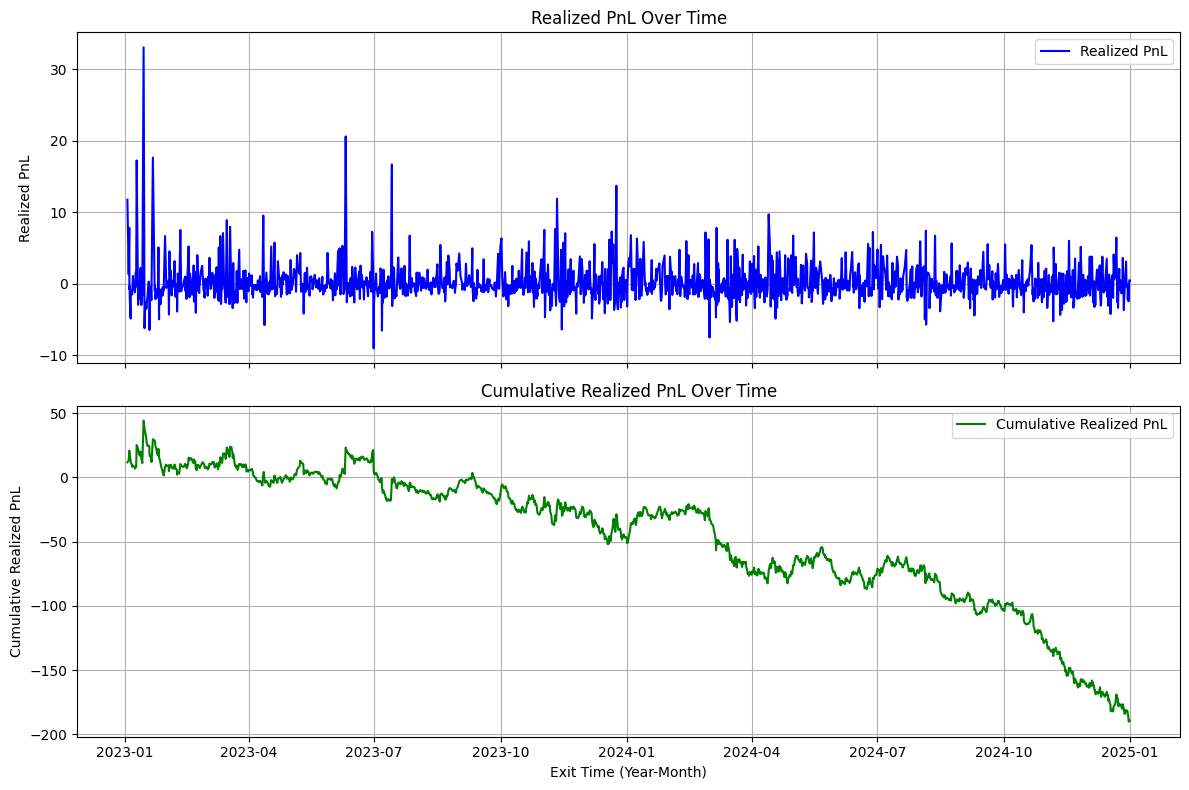

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

backtest_trade_sim_plot = upgraded_df.copy()

# Convert exit_time from UNIX milliseconds to UTC+0 datetime
backtest_trade_sim_plot['exit_time_utc'] = pd.to_datetime(
    backtest_trade_sim_plot['close_time'], unit='ms', utc=True
)

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Realized PnL vs Exit Time
ax[0].plot(backtest_trade_sim_plot['exit_time_utc'], backtest_trade_sim_plot['PnL'], label='Realized PnL', color='blue')
ax[0].set_title('Realized PnL Over Time')
ax[0].set_ylabel('Realized PnL')

# Cumulative Realized PnL vs Exit Time
ax[1].plot(backtest_trade_sim_plot['exit_time_utc'], backtest_trade_sim_plot['cumulative_pnl'], label='Cumulative Realized PnL', color='green')
ax[1].set_title('Cumulative Realized PnL Over Time')
ax[1].set_ylabel('Cumulative Realized PnL')

# Format x-axis to show year and month
ax[1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
ax[1].set_xlabel('Exit Time (Year-Month)')

# Improve layout and add gridlines
for axis in ax:
    axis.grid(True)
    axis.legend()

plt.tight_layout()
plt.show()

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def plot_realized_pnl(backtest_trade_sim):
    backtest_trade_sim_plot = backtest_trade_sim.copy()

    # Convert exit_time from UNIX milliseconds to UTC+0 datetime
    backtest_trade_sim_plot['exit_time_utc'] = pd.to_datetime(
        backtest_trade_sim_plot['exit_time'], unit='s', utc=True
    )

    # Plotting
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Realized PnL vs Exit Time
    ax[0].plot(backtest_trade_sim_plot['exit_time_utc'], backtest_trade_sim_plot['realized_pnl'], label='Realized PnL', color='blue')
    ax[0].set_title('Realized PnL Over Time')
    ax[0].set_ylabel('Realized PnL')

    # Cumulative Realized PnL vs Exit Time
    ax[1].plot(backtest_trade_sim_plot['exit_time_utc'], backtest_trade_sim_plot['cumulative_realized_pnl'], label='Cumulative Realized PnL', color='green')
    ax[1].set_title('Cumulative Realized PnL Over Time')
    ax[1].set_ylabel('Cumulative Realized PnL')

    # Format x-axis to show year and month
    ax[1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    ax[1].set_xlabel('Exit Time (Year-Month)')

    # Improve layout and add gridlines
    for axis in ax:
        axis.grid(True)
        axis.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_realized_pnl(backtest_trade_sim)

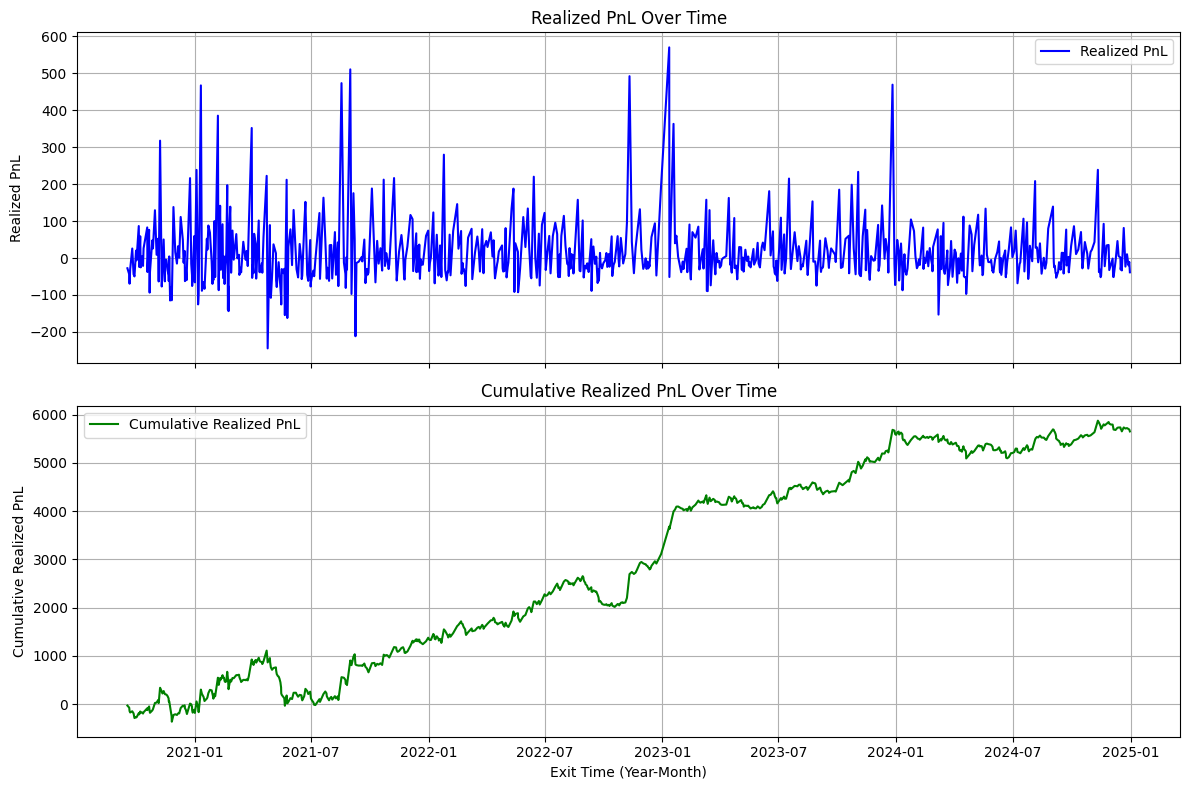

In [27]:
plot_realized_pnl(backtest_trade_sim)

# All Functions

In [2]:
# Super Trend Indicator

import pandas as pd
import numpy as np
from pandas_ta.overlap import hl2
from pandas_ta.volatility import atr
from pandas_ta.utils import get_offset, verify_series

# npNaN = np.nan

def calculate_supertrend(df, high_col='highprice', low_col='lowprice', close_col='closeprice', length=10, multiplier=3.0, offset=0, drop_columns=True, **kwargs):
    """
    Calculate the Supertrend indicator and merge it with the original DataFrame.
    
    Parameters:
        df (DataFrame): Original DataFrame containing the OHLC data.
        high_col (str): Name of the high price column. Default is 'highprice'.
        low_col (str): Name of the low price column. Default is 'lowprice'.
        close_col (str): Name of the close price column. Default is 'closeprice'.
        length (int): Lookback period for ATR calculation. Default is 10.
        multiplier (float): Multiplier for ATR. Default is 3.0.
        offset (int): Number of periods to shift the result. Default is 0.
        drop_columns (bool): Whether to drop intermediate columns. Default is True.
        **kwargs: Additional arguments for handling NaN values (e.g., fillna).
    
    Returns:
        DataFrame: The original DataFrame with Supertrend columns merged.
    """
    # Validate Arguments
    high = verify_series(df[high_col], length)
    low = verify_series(df[low_col], length)
    close = verify_series(df[close_col], length)
    offset = get_offset(offset)

    if high is None or low is None or close is None:
        return df

    m = close.size
    dir_, trend = [1] * m, [0] * m
    long, short = [np.nan] * m, [np.nan] * m

    hl2_ = hl2(high, low)
    matr = multiplier * atr(high, low, close, length)
    upperband = hl2_ + matr
    lowerband = hl2_ - matr

    for i in range(1, m):
        if close.iloc[i] > upperband.iloc[i - 1]:
            dir_[i] = 1
        elif close.iloc[i] < lowerband.iloc[i - 1]:
            dir_[i] = -1
        else:
            dir_[i] = dir_[i - 1]
            if dir_[i] > 0 and lowerband.iloc[i] < lowerband.iloc[i - 1]:
                lowerband.iloc[i] = lowerband.iloc[i - 1]
            if dir_[i] < 0 and upperband.iloc[i] > upperband.iloc[i - 1]:
                upperband.iloc[i] = upperband.iloc[i - 1]

        if dir_[i] > 0:
            trend[i] = long[i] = lowerband.iloc[i]
        else:
            trend[i] = short[i] = upperband.iloc[i]

    _props = f"_{length}_{multiplier}"
    supertrend_df = pd.DataFrame({
        f"SUPERT{_props}": trend,
        f"SUPERTd{_props}": dir_,
        f"SUPERTl{_props}": long,
        f"SUPERTs{_props}": short,
    }, index=close.index)

    # Apply offset if needed
    if offset != 0:
        supertrend_df = supertrend_df.shift(offset)

    # Handle fills
    if "fillna" in kwargs:
        supertrend_df.fillna(kwargs["fillna"], inplace=True)
    if "fill_method" in kwargs:
        supertrend_df.fillna(method=kwargs["fill_method"], inplace=True)

    # Merge with original DataFrame
    result_df = df.join(supertrend_df)

    # Drop unnecessary columns
    if drop_columns:
        result_df.drop(columns=[f"SUPERT{_props}", f"SUPERTd{_props}"], inplace=True)

    return result_df

In [3]:
# Ichimoku Cloud Indicator

import pandas as pd
import numpy as np

def compute_ichimoku_with_supertrend(supertrend_df, conversion_periods=9, base_periods=26, span_b_periods=52, displacement=26):
    """
    Compute Ichimoku Cloud components and join them with the original supertrend DataFrame.
    
    Parameters:
    - supertrend_df (DataFrame): The input DataFrame with 'highprice', 'lowprice', and 'closeprice' columns.
    - conversion_periods (int): Period for the Conversion Line (Tenkan-sen). Default is 9.
    - base_periods (int): Period for the Base Line (Kijun-sen). Default is 26.
    - span_b_periods (int): Period for Leading Span B (Senkou Span B). Default is 52.
    - displacement (int): Displacement for Leading Spans. Default is 26.
    
    Returns:
    - DataFrame: A DataFrame that combines the original supertrend DataFrame with the computed Ichimoku Cloud components.
    """
    # Helper to calculate the average of the highest high and lowest low
    def donchian(data, period):
        return (data['highprice'].rolling(window=period).max() + 
                data['lowprice'].rolling(window=period).min()) / 2

    # Compute Ichimoku Cloud components
    supertrend_df['conversion_line'] = donchian(supertrend_df, conversion_periods)
    supertrend_df['base_line'] = donchian(supertrend_df, base_periods)
    supertrend_df['leading_span_a'] = ((supertrend_df['conversion_line'] + supertrend_df['base_line']) / 2).shift(displacement)
    supertrend_df['leading_span_b'] = donchian(supertrend_df, span_b_periods).shift(displacement)
    supertrend_df['lagging_span'] = supertrend_df['closeprice'].shift(-displacement)
    
    # Drop unnecessary columns
    supertrend_df.drop(columns=['conversion_line', 'base_line', 'lagging_span'], inplace=True)
    
    return supertrend_df

In [4]:
# Back Test Signaling

import numpy as np
import pandas as pd

def generate_backtest_trade_recap(df):
    # Step 1: Rename columns
    new_column_names = {
        'opentime': 'time',
        'openprice': 'open',
        'highprice': 'high',
        'lowprice': 'low',
        'closeprice': 'close',
        'SUPERTl_10_3.0': 'Up Trend',
        'SUPERTs_10_3.0': 'Down Trend',
        'leading_span_a': 'Leading Span A',
        'leading_span_b': 'Leading Span B',
    }
    df.rename(columns=new_column_names, inplace=True)

    # Step 2: Drop rows 0 to 50
    df.drop(index=range(51), inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Step 3: Set 'super_trend'
    df['super_trend'] = np.where(df['Down Trend'].isna(), 1, 
                                 np.where(df['Up Trend'].isna(), -1, np.nan))

    # Step 4: Define criteria
    def determine_criteria_pass(row):
        if row['super_trend'] == 1 and row['open'] > max(row['Leading Span A'], row['Leading Span B']):
            return 1
        elif row['super_trend'] == -1 and row['open'] < min(row['Leading Span A'], row['Leading Span B']):
            return 1
        return 0

    df['criteria'] = df.apply(determine_criteria_pass, axis=1)

    # Step 5: Assign actions
    df['action'] = None
    df['action'] = np.where((df['super_trend'] == 1) & (df['criteria'] == 1), 'long', df['action'])
    df['action'] = np.where((df['super_trend'] == -1) & (df['criteria'] == 1), 'short', df['action'])

    # Step 6: Identify trend changes
    df['trend_change'] = np.where(df['super_trend'].shift(1) != df['super_trend'], 1, 0)
    df['time'] = (df['time'] / 1000).astype(int)

    # Step 7: Filter trade history
    df_action_close = df[df['trend_change'] == 1]
    index_list = df_action_close.index.tolist()
    consecutive_pairs = [(index_list[i], index_list[i + 1]) for i in range(len(index_list) - 1)]

    # Step 8: Process pairs
    def process_consecutive_pairs(df, pairs):
        result_pairs = []
        for start_idx, end_idx in pairs:
            sub_df = df.iloc[start_idx:end_idx + 1]
            actions = sub_df['action']
            long_short_indices = actions[actions.isin(['long', 'short'])]
            if not long_short_indices.empty:
                first_action_idx = long_short_indices.index[0]
                result_pairs.append((first_action_idx, end_idx))
        return result_pairs

    result = process_consecutive_pairs(df, consecutive_pairs)

    # Step 9: Remove duplicate indices
    filtered_result = [(start_idx, end_idx) for start_idx, end_idx in result if start_idx != end_idx]

    # Step 10: Generate recap DataFrame
    results = []
    for start_idx, end_idx in filtered_result:
        position = df.loc[start_idx, 'action']
        open_time = df.loc[start_idx, 'time']
        open_price = df.loc[start_idx, 'open']
        exit_time = df.loc[end_idx, 'time']
        exit_price = df.loc[end_idx, 'close']

        sub_df = df.iloc[start_idx:end_idx + 1]
        min_price = sub_df['low'].min()
        max_price = sub_df['high'].max()

        results.append({
            "position": position,
            "open_time": open_time,
            "open_price": open_price,
            "exit_time": exit_time,
            "exit_price": exit_price,
            "min_price": min_price,
            "max_price": max_price
        })

    return pd.DataFrame(results)

In [5]:
import pandas as pd
import numpy as np

def backtest_trade_summary(backtest_trade_recap, taker_fee=0.0005, funding_rate=0.0001, position='both'):
    backtest_trade_sim = backtest_trade_recap.copy()

    # Initialize columns
    backtest_trade_sim['balance'] = 1000
    backtest_trade_sim['open_fee'] = 0
    backtest_trade_sim['exit_fee'] = 0
    backtest_trade_sim['realized_pnl'] = 0

    # Calculate open_fee
    backtest_trade_sim['open_fee'] = backtest_trade_sim['balance'] * taker_fee

    # Calculate exit_fee
    backtest_trade_sim['exit_fee'] = (
        (backtest_trade_sim['balance'] / backtest_trade_sim['open_price']) * 
        backtest_trade_sim['exit_price'] * taker_fee
    )

    # Calculate position hold time in hours
    backtest_trade_sim['hold_time'] = (backtest_trade_sim['exit_time'] - backtest_trade_sim['open_time']) / 3600

    # Calculate how many times funding fee occurs
    backtest_trade_sim['funding_fee_occurence'] = backtest_trade_sim['hold_time'] // 8

    # Calculate funding_fee
    backtest_trade_sim['funding_fee'] = (
        backtest_trade_sim['balance'] * 
        backtest_trade_sim['funding_fee_occurence'] * 
        funding_rate
    )

    # Filter by position if necessary
    if position == 'long':
        backtest_trade_sim = backtest_trade_sim[backtest_trade_sim['position'] == 'long']
    elif position == 'short':
        backtest_trade_sim = backtest_trade_sim[backtest_trade_sim['position'] == 'short']
    # If position is 'both', no filtering is applied

    # Function to calculate realized PnL
    def calculate_realized_pnl(row):
        position = row['position']
        balance = row['balance']
        open_price = row['open_price']
        exit_price = row['exit_price']
        open_fee = row['open_fee']
        exit_fee = row['exit_fee']
        funding_fee = row['funding_fee']

        if position == 'short':
            return balance - (balance / open_price * exit_price) - open_fee - exit_fee - funding_fee
        elif position == 'long':
            return (balance / open_price * exit_price) - balance - open_fee - exit_fee - funding_fee
        return 0  # Default case, should not be reached

    # Calculate realized PnL for each trade
    backtest_trade_sim['realized_pnl'] = backtest_trade_sim.apply(calculate_realized_pnl, axis=1)

    # Calculate cumulative realized profit and loss
    backtest_trade_sim['cumulative_realized_pnl'] = backtest_trade_sim['realized_pnl'].cumsum()

    # Define trade win/loss
    backtest_trade_sim['win_loss'] = np.where(backtest_trade_sim['realized_pnl'] >= 0, 'Win', 'Lose')

    # Count of positions (number and percentage)
    position_counts = backtest_trade_sim['position'].value_counts()
    position_percentages = position_counts / len(backtest_trade_sim) * 100

    # Realized PnL statistics
    realized_pnl_stats = {
        'max': backtest_trade_sim['realized_pnl'].max(),
        'min': backtest_trade_sim['realized_pnl'].min(),
        'avg': backtest_trade_sim['realized_pnl'].mean(),
        'median': backtest_trade_sim['realized_pnl'].median(),
    }

    # Hold time statistics
    hold_time_stats = {
        'max': backtest_trade_sim['hold_time'].max(),
        'min': backtest_trade_sim['hold_time'].min(),
        'avg': backtest_trade_sim['hold_time'].mean(),
        'median': backtest_trade_sim['hold_time'].median(),
    }

    # Win rate (overall)
    total_trades = len(backtest_trade_sim)
    wins = (backtest_trade_sim['realized_pnl'] >= 0).sum()
    win_rate = wins / total_trades * 100

    # Win rate per position (long/short)
    win_rate_by_position = (
        backtest_trade_sim.groupby('position')['realized_pnl']
        .apply(lambda x: (x >= 0).sum() / len(x) * 100)
    )

    # Results dictionary
    results = {
        "Position Counts": position_counts.to_dict(),
        "Position Percentages": position_percentages.to_dict(),
        "Realized PnL Stats": realized_pnl_stats,
        "Hold Time Stats": hold_time_stats,  # Add hold time stats
        "Overall Win Rate": win_rate,
        "Win Rate by Position": win_rate_by_position.to_dict(),
    }

    # Latest row of the cumulative PnL
    latest_cumulative_pnl = backtest_trade_sim['cumulative_realized_pnl'].iloc[-1]
    results['Cumulative PnL'] = latest_cumulative_pnl

    # Add total number of trades
    results['Total Long + Short Trades'] = total_trades

    return backtest_trade_sim, results

In [6]:
def longest_consecutive_losses_with_cumsum(df):
    # Identify whether each row is a loss (Win -> 0, Lose -> 1)
    df['is_loss'] = (df['win_loss'] == 'Lose').astype(int)

    # Compute the sequence groups of consecutive losses
    df['group'] = (df['is_loss'] != df['is_loss'].shift()).cumsum()

    # Filter only loss groups
    loss_groups = df[df['is_loss'] == 1].groupby('group').size()

    # Find the longest loss sequence
    max_loss_group = loss_groups.idxmax()

    # Extract rows corresponding to the longest consecutive loss group
    result_df = df[df['group'] == max_loss_group][['position', 'realized_pnl']].reset_index(drop=True)

    # Calculate cumulative sum of the realized_pnl column
    result_df['cumsum_realized_pnl'] = result_df['realized_pnl'].cumsum()

    return result_df

In [7]:
import pandas as pd

def find_min_rel_cum_realized_pnl(backtest_trade_sim):
    """
    This function iterates through each row in the 'backtest_trade_sim' DataFrame,
    slices the DataFrame from the current row to the end, recalculates the 
    'rel_cum_realized_pnl', and returns the overall minimum 'rel_cum_realized_pnl'
    value and the corresponding sliced DataFrame up to the row where the minimum 
    occurred.
    
    Parameters:
    backtest_trade_sim (pd.DataFrame): The DataFrame containing trade data
    
    Returns:
    tuple: A tuple containing the minimum 'rel_cum_realized_pnl' value and the 
           sliced DataFrame producing that minimum.
    """
    # Initialize the variable to track the overall minimum rel_cum_realized_pnl
    min_rel_cum_realized_pnl = float('inf')
    min_slice_df = None  # To store the sliced DataFrame producing the minimum value

    # Iterate through each row and slice the DataFrame from the current row to the end
    for i in range(len(backtest_trade_sim)):
        # Slice the DataFrame from the current row to the last
        sliced_df = backtest_trade_sim.iloc[i:].copy()  # Make a copy to avoid SettingWithCopyWarning
        
        # Recalculate the relative cumulative realized pnl
        sliced_df['rel_cum_realized_pnl'] = sliced_df['realized_pnl'].cumsum()
        
        # Find the minimum value of the newly calculated 'rel_cum_realized_pnl'
        min_in_iteration = sliced_df['rel_cum_realized_pnl'].min()
        
        # Track the overall minimum rel_cum_realized_pnl and the corresponding sliced DataFrame
        if min_in_iteration < min_rel_cum_realized_pnl:
            min_rel_cum_realized_pnl = min_in_iteration
            # Get the row where the minimum occurred
            min_row_index = sliced_df['rel_cum_realized_pnl'].idxmin()
            min_slice_df = sliced_df.loc[:min_row_index]  # Slice until the row with the minimum value

    return min_rel_cum_realized_pnl, min_slice_df

In [8]:
# Plot Cummulative PnL

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def plot_realized_pnl(backtest_trade_sim):
    backtest_trade_sim_plot = backtest_trade_sim.copy()

    # Convert exit_time from UNIX milliseconds to UTC+0 datetime
    backtest_trade_sim_plot['exit_time_utc'] = pd.to_datetime(
        backtest_trade_sim_plot['exit_time'], unit='s', utc=True
    )

    # Plotting
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Realized PnL vs Exit Time
    ax[0].plot(backtest_trade_sim_plot['exit_time_utc'], backtest_trade_sim_plot['realized_pnl'], label='Realized PnL', color='blue')
    ax[0].set_title('Realized PnL Over Time')
    ax[0].set_ylabel('Realized PnL')

    # Cumulative Realized PnL vs Exit Time
    ax[1].plot(backtest_trade_sim_plot['exit_time_utc'], backtest_trade_sim_plot['cumulative_realized_pnl'], label='Cumulative Realized PnL', color='green')
    ax[1].set_title('Cumulative Realized PnL Over Time')
    ax[1].set_ylabel('Cumulative Realized PnL')

    # Format x-axis to show year and month
    ax[1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    ax[1].set_xlabel('Exit Time (Year-Month)')

    # Improve layout and add gridlines
    for axis in ax:
        axis.grid(True)
        axis.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_realized_pnl(backtest_trade_sim)

# GET DATA

In [14]:
import requests
import pandas as pd
from datetime import datetime
from tqdm import tqdm

BINANCE_CANDLE_COLUMNS = ['opentime', 'openprice', 'highprice', 'lowprice', 'closeprice', 'volume', 'closetime',
                          'quotevolume', 'trades', 'taker_buy_volume', 'taker_buy_quote', 'unused']

def binance_recursive_fetch_2(coins, interval, starttime, endtime, data_type='spot'):
    all_coins_result = {}
    data_list = []
    call_dict = {}
    
    for coin in tqdm(coins):
        result_list = []
        current_time = starttime
        call = 0
        timestamps = []
        
        while current_time < endtime:
            if ((int((endtime - current_time) / (1000 * 60))) + 1) >= 1000:
                limit = 1000
            else:
                limit = int((endtime - current_time) / (1000 * 60) + 1)
            
            if data_type == 'spot':
                url = (f'https://api.binance.com/api/v3/klines'
                       f'?symbol={coin}USDT'
                       f'&startTime={str(current_time)}'
                       f'&interval={interval}'
                       f'&limit={str(limit)}')
            elif data_type == 'futures':
                url = (f'https://fapi.binance.com/fapi/v1/klines'
                       f'?symbol={coin}USDT'
                       f'&startTime={str(current_time)}'
                       f'&interval={interval}'
                       f'&limit={str(limit)}')
            
            result_list += requests.get(url).json()
            
            if result_list:
                # Update current_time with the timestamp of the last data point fetched, plus 1 minute (60000 ms)
                current_time = result_list[-1][0] + 60000
                timestamps.append(current_time)
                call += 1
                
                # Check if the last fetched timestamp is greater than or equal to endtime
                if current_time >= endtime:
                    print(f"Reached endtime at {datetime.fromtimestamp(current_time / 1000).strftime('%Y-%m-%d %H:%M:%S')}. Stopping fetch.")
                    break
                
                print((datetime.fromtimestamp(current_time / 1000).strftime('%Y-%m-%d %H:%M:%S')) + 
                      f' status : {current_time < endtime}, time : {current_time}, limit : {call * 2}')
            
            # Ensure there's no continuous fetching of the same timestamp
            if len(timestamps) > 1 and timestamps[-1] == timestamps[-2]:
                print("Duplicate timestamp detected. Stopping fetch.")
                break
            
            # Sleep if needed to avoid rate limiting (adjust based on your rate limit)
            # time.sleep(0.1)  # Uncomment if needed
            
        current_df = pd.DataFrame(result_list, columns=BINANCE_CANDLE_COLUMNS)
        current_df['coin'] = coin
        current_df = current_df[['coin'] + BINANCE_CANDLE_COLUMNS]
        current_df = current_df.values.tolist()
        
        data_list += current_df
        call_dict.update({coin: call})
    
    return {'data': data_list, 'call': call_dict}

In [17]:
# Fetch COIN USDT
sample_spot = binance_recursive_fetch_2(
    ['SOL'],
    '30m',
    starttime=int(pd.to_datetime('2023-01-01 00:00', utc=True).timestamp() * 1000),
    endtime=int(pd.to_datetime('2026-01-01 00:00', utc=True).timestamp() * 1000),
    data_type='futures'  # Fetch futures/sport
)

# Define the column names for the DataFrame based on the Binance API response structure
columns = ['coin', 'opentime', 'openprice', 'highprice', 'lowprice', 'closeprice', 'volume', 'closetime', 
           'quotevolume', 'trades', 'taker_buy_volume', 'taker_buy_quote', 'unused']

# Convert the list of data into a DataFrame
df = pd.DataFrame(sample_spot['data'], columns=columns)

# Drop unnecessary columns
df.drop(columns=(['coin','volume','closetime','quotevolume','trades','taker_buy_volume','taker_buy_quote','unused']), inplace=True)

# Convert columns 1-4 (openprice, highprice, lowprice, closeprice) to float
df[['openprice', 'highprice', 'lowprice', 'closeprice']] = df[['openprice', 'highprice', 'lowprice', 'closeprice']].apply(pd.to_numeric, errors='coerce')

# add date filter
df = df[df['opentime'] <= 1735689600000] # end of 2024

# Show the first few rows of the DataFrame
df

  0%|          | 0/1 [00:00<?, ?it/s]

2023-01-21 19:31:00 status : True, time : 1674329460000, limit : 2
2023-02-11 15:31:00 status : True, time : 1676129460000, limit : 4
2023-03-04 11:31:00 status : True, time : 1677929460000, limit : 6
2023-03-25 07:31:00 status : True, time : 1679729460000, limit : 8
2023-04-15 03:31:00 status : True, time : 1681529460000, limit : 10
2023-05-05 23:31:00 status : True, time : 1683329460000, limit : 12
2023-05-26 19:31:00 status : True, time : 1685129460000, limit : 14
2023-06-16 15:31:00 status : True, time : 1686929460000, limit : 16
2023-07-07 11:31:00 status : True, time : 1688729460000, limit : 18
2023-07-28 07:31:00 status : True, time : 1690529460000, limit : 20
2023-08-18 03:31:00 status : True, time : 1692329460000, limit : 22
2023-09-07 23:31:00 status : True, time : 1694129460000, limit : 24
2023-09-28 19:31:00 status : True, time : 1695929460000, limit : 26
2023-10-19 15:31:00 status : True, time : 1697729460000, limit : 28
2023-11-09 11:31:00 status : True, time : 1699529460

100%|██████████| 1/1 [00:04<00:00,  4.16s/it]


,opentime,openprice,highprice,lowprice,closeprice
0,1672531200000,9.968,10.016,9.923,10.011
1,1672533000000,10.011,10.012,9.931,9.979
2,1672534800000,9.980,10.060,9.970,10.037
3,1672536600000,10.037,10.059,10.003,10.032
4,1672538400000,10.031,10.074,9.981,10.044
...,...,...,...,...,...
35084,1735682400000,193.050,193.050,191.140,191.920
35085,1735684200000,191.930,192.130,190.590,191.070
35086,1735686000000,191.070,191.080,189.860,190.430
35087,1735687800000,190.420,190.420,189.040,189.220


# BACKTEST

In [36]:
# Add supertrend indicator
supertrend_df = calculate_supertrend(df, length=10, multiplier=3.0)

# Add ichimoku indicator
supertrend_ichimoku_df = compute_ichimoku_with_supertrend(supertrend_df)

# Create position signal
backtest_trade_recap = generate_backtest_trade_recap(supertrend_ichimoku_df)

In [41]:
# Calculate the backtest
backtest_trade_sim, results = backtest_trade_summary(backtest_trade_recap)
# backtest_trade_sim, results = backtest_trade_summary(backtest_trade_recap, position='long')
# backtest_trade_sim, results = backtest_trade_summary(backtest_trade_recap, position='short')

# Show the statistics
results

{'Position Counts': {'long': 6},
 'Position Percentages': {'long': 100.0},
 'Realized PnL Stats': {'max': np.float64(26.60751519818385),
  'min': np.float64(-8.841534176198106),
  'avg': np.float64(4.219327685226621),
  'median': np.float64(-4.68969660315627)},
 'Hold Time Stats': {'max': np.float64(79.5),
  'min': np.float64(1.5),
  'avg': np.float64(29.166666666666668),
  'median': np.float64(23.75)},
 'Overall Win Rate': np.float64(33.33333333333333),
 'Win Rate by Position': {'long': 33.33333333333333},
 'Cumulative PnL': np.float64(25.315966111359728),
 'Total Long + Short Trades': 6}

In [44]:
# Apply the function
longest_loss_with_cumsum_df = longest_consecutive_losses_with_cumsum(backtest_trade_sim)
print(longest_loss_with_cumsum_df)

NameError: name 'longest_consecutive_losses_with_cumsum' is not defined

In [43]:
# Assuming 'backtest_trade_sim' is your DataFrame
min_value, min_slice_df = find_min_rel_cum_realized_pnl(backtest_trade_sim)

print(f'Max drawdown :{min_value} USDT')
# print(min_slice_df)

Max drawdown :-23.499147597509612 USDT


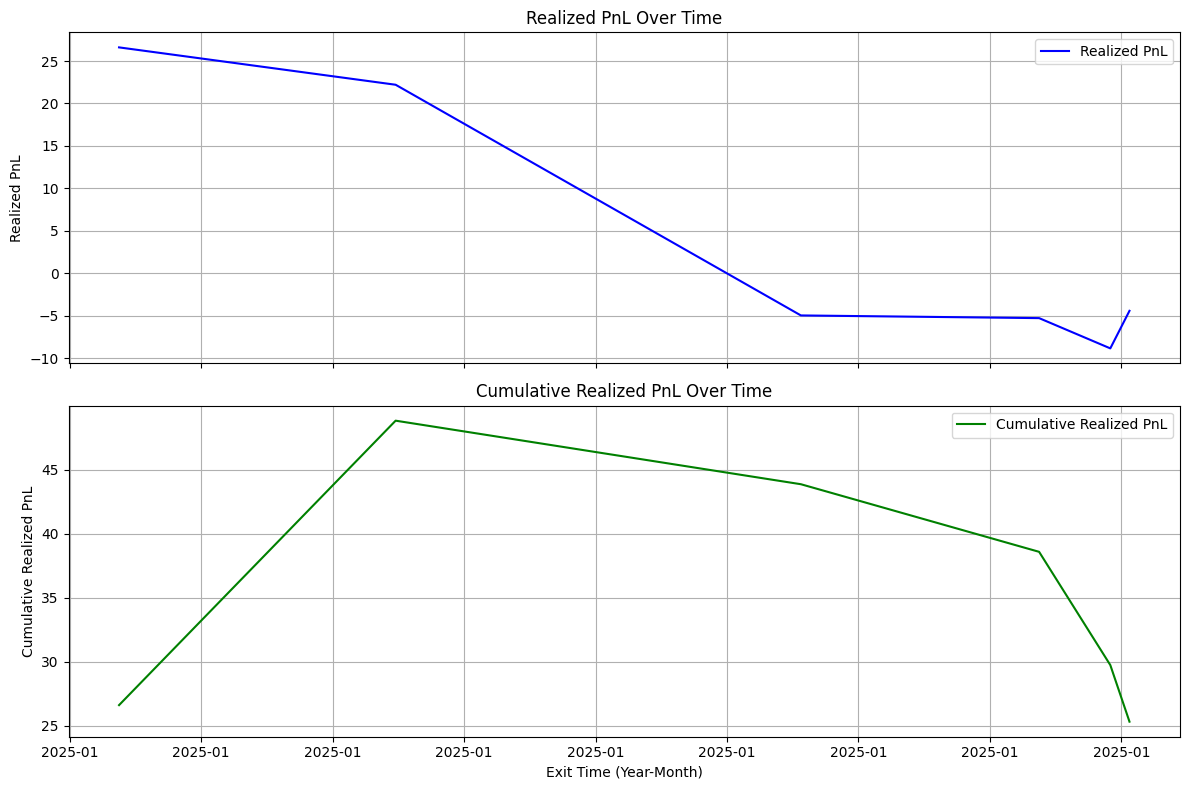

In [44]:
# Plot Cumullative pnl
plot_realized_pnl(backtest_trade_sim)

# Calculate Sharpe ratio

In [16]:
equity = backtest_trade_sim.copy()

equity = equity[['cumulative_realized_pnl']]

equity['cumulative_realized_pnl'] = equity['cumulative_realized_pnl'] + 10000

# Calculate daily strategy returns (percentage change in equity)
equity['strategy_returns'] = equity['cumulative_realized_pnl'].pct_change()

# Remove the NaN (first row, which has no previous row to compare)
equity.dropna(subset=['strategy_returns'], inplace=True)

# Risk-free rate (annualized 4.28% converted to daily for crypto, 365 days in a year)
risk_free_rate = 0.0428 / 365  # Daily risk-free rate for crypto market

# Continue with the same calculations
equity['excess_returns'] = equity['strategy_returns'] - risk_free_rate
average_excess_return = equity['excess_returns'].mean()
std_dev_excess_return = equity['excess_returns'].std()
sharpe_ratio = average_excess_return / std_dev_excess_return

# Print the Sharpe Ratio
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Optionally, to annualize the Sharpe Ratio (for crypto):
annualized_sharpe_ratio = sharpe_ratio * np.sqrt(365)
print(f"Annualized Sharpe Ratio: {annualized_sharpe_ratio:.2f}")


Sharpe Ratio: 0.04
Annualized Sharpe Ratio: 0.75
